# Binary Classification

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### Device Agnostic Code

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

### Data PreProcessing

In [36]:
data = pd.read_csv('./dataset-classification/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [37]:
data = data[['Age', 'Sex', 'RestingBP', 'Cholesterol', 'MaxHR', 'HeartDisease']]
data.head()

,Age,Sex,RestingBP,Cholesterol,MaxHR,HeartDisease
0,40,M,140,289,172,0
1,49,F,160,180,156,1
2,37,M,130,283,98,0
3,48,F,138,214,108,1
4,54,M,150,195,122,0


In [38]:
X = data[['Age', 'Sex', 'RestingBP', 'Cholesterol', 'MaxHR']]
y = data['HeartDisease']

y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

In [39]:
# convert sex to numerical value

X = X.replace({'M':1, 'F':0})

X.head()

/tmp/ipykernel_706369/1854787251.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({'M':1, 'F':0})


,Age,Sex,RestingBP,Cholesterol,MaxHR
0,40,1,140,289,172
1,49,0,160,180,156
2,37,1,130,283,98
3,48,0,138,214,108
4,54,1,150,195,122


In [40]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(X)

features_scaled

array([[-1.4331398 ,  0.51595242,  0.41090889,  0.82507026,  1.38292822],
       [-0.47848359, -1.93816322,  1.49175234, -0.17196105,  0.75415714],
       [-1.75135854,  0.51595242, -0.12951283,  0.7701878 , -1.52513802],
       ...,
       [ 0.37009972,  0.51595242, -0.12951283, -0.62016778, -0.85706875],
       [ 0.37009972, -1.93816322, -0.12951283,  0.34027522,  1.4615246 ],
       [-1.64528563,  0.51595242,  0.30282455, -0.21769643,  1.42222641]])

### Split the data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=60)

### Convert Dataframes to Tensors

In [42]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [43]:
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.float32).to(device)

In [44]:
X_train.shape, y_train.shape, X_train.dim(), y_train.dim()

(torch.Size([688, 5]), torch.Size([688]), 2, 1)

In [45]:
X_train[:5], y_train[:5]

(tensor([[ 51.,   0., 130., 305., 142.],
         [ 47.,   1., 150., 226.,  98.],
         [ 66.,   1., 160., 246., 120.],
         [ 57.,   1., 110., 197., 100.],
         [ 54.,   0., 110., 214., 158.]]),
 tensor([1., 1., 1., 0., 0.]))

### Creating Model

In [46]:
class myModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=5, out_features=12)
        self.layer2 = nn.Linear(in_features=12, out_features=22)
        self.layer3 = nn.Linear(in_features=22, out_features=12)
        self.layer4 = nn.Linear(in_features=12, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer4(self.relu(self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))))

In [47]:
model = myModel().to(device)

model

myModel(
  (layer1): Linear(in_features=5, out_features=12, bias=True)
  (layer2): Linear(in_features=12, out_features=22, bias=True)
  (layer3): Linear(in_features=22, out_features=12, bias=True)
  (layer4): Linear(in_features=12, out_features=1, bias=True)
  (relu): ReLU()
)

### Calculate Accuracy Function

In [48]:
def accuracy_fn(y_pred, y_actual):
    assert y_pred.shape == y_actual.shape
    correct = torch.eq(y_pred, y_actual).sum().item()
    accuracy = (correct / len(y_actual)) 
    return accuracy

### Setup Loss Function and Optimizer

In [49]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)

### Plotting Function

In [50]:
def plot_fn(x, y, label, title):
    plt.subplots(1, 2, figsize=(12, 5))
    plt.plot(x, y, label=label)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.legend()
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

In [51]:
def plot_side_by_side(epochs, loss, accuracy, label_train_test):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot on the first subplot (left)
    ax[0].plot(epochs, loss, label='Loss', color='blue')
    ax[0].set_title(f'{label_train_test} Loss Over Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot on the second subplot (right)
    ax[1].plot(epochs, accuracy, label='Accuracy', color='red')
    ax[1].set_title(f'{label_train_test} Accuracy Over Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

### Training the model

In [52]:
X_train.size(), y_train.size(), X_test.size(), y_test.size()

(torch.Size([688, 5]),
 torch.Size([688]),
 torch.Size([230, 5]),
 torch.Size([230]))

In [53]:
train_loss, train_accu, test_loss, test_accu, epoch_arr = [], [], [], [], []

In [54]:
epochs = 20000

for epoch in range(epochs):

    model.train()

    # forward pass
    y_logits = model(X_train)
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss and accuracy
    loss = loss_fn(y_logits.squeeze(), y_train)
    accu = accuracy_fn(y_pred.squeeze(), y_train)

    # optimizer
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # step the optimizer
    optimizer.step()

    # calulcating loss and accuracy for test data
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))

        loss_te = loss_fn(test_logits.squeeze(), y_test)
        accu_te = accuracy_fn(test_pred.squeeze(), y_test)
    
    if epoch % 500 == 0:
        print(f'Epoch: {epoch} | Train Loss: {loss:.2f} | Train Accuracy: {accu:.2f} |Test Loss: {loss_te:.2f} | Test Accuracy: {accu_te:.2f}')
        train_loss.append(loss)
        train_accu.append(accu)
        test_loss.append(loss_te)
        test_accu.append(accu_te)
        epoch_arr.append(epoch)

Epoch: 0 | Train Loss: 1.94 | Train Accuracy: 0.54 |Test Loss: 1.81 | Test Accuracy: 0.59
Epoch: 500 | Train Loss: 0.68 | Train Accuracy: 0.52 |Test Loss: 0.67 | Test Accuracy: 0.57
Epoch: 1000 | Train Loss: 0.67 | Train Accuracy: 0.58 |Test Loss: 0.66 | Test Accuracy: 0.59
Epoch: 1500 | Train Loss: 0.67 | Train Accuracy: 0.58 |Test Loss: 0.66 | Test Accuracy: 0.59
Epoch: 2000 | Train Loss: 0.66 | Train Accuracy: 0.58 |Test Loss: 0.66 | Test Accuracy: 0.59
Epoch: 2500 | Train Loss: 0.66 | Train Accuracy: 0.59 |Test Loss: 0.66 | Test Accuracy: 0.60
Epoch: 3000 | Train Loss: 0.66 | Train Accuracy: 0.59 |Test Loss: 0.66 | Test Accuracy: 0.60
Epoch: 3500 | Train Loss: 0.66 | Train Accuracy: 0.60 |Test Loss: 0.65 | Test Accuracy: 0.62
Epoch: 4000 | Train Loss: 0.66 | Train Accuracy: 0.61 |Test Loss: 0.65 | Test Accuracy: 0.63
Epoch: 4500 | Train Loss: 0.66 | Train Accuracy: 0.61 |Test Loss: 0.65 | Test Accuracy: 0.65
Epoch: 5000 | Train Loss: 0.66 | Train Accuracy: 0.62 |Test Loss: 0.65 | T

In [55]:
train_loss = [ loss.item() for loss in train_loss] 
test_loss = [ loss.item() for loss in test_loss ]

In [56]:
# plot_loss_accuracy(epoch_arr, train_loss, epoch_arr, train_accu, 'Training Loss', 'Training Accuracy', 'LOss and Accuracy of Training Data')
# plot_loss_accuracy(epoch_arr, test_loss, epoch_arr, test_accu, 'Testing Loss', 'Testing Accuracy', 'LOss and Accuracy of Testing Data')

#### Plotting Loss and Accuracy over epochs for Training Data

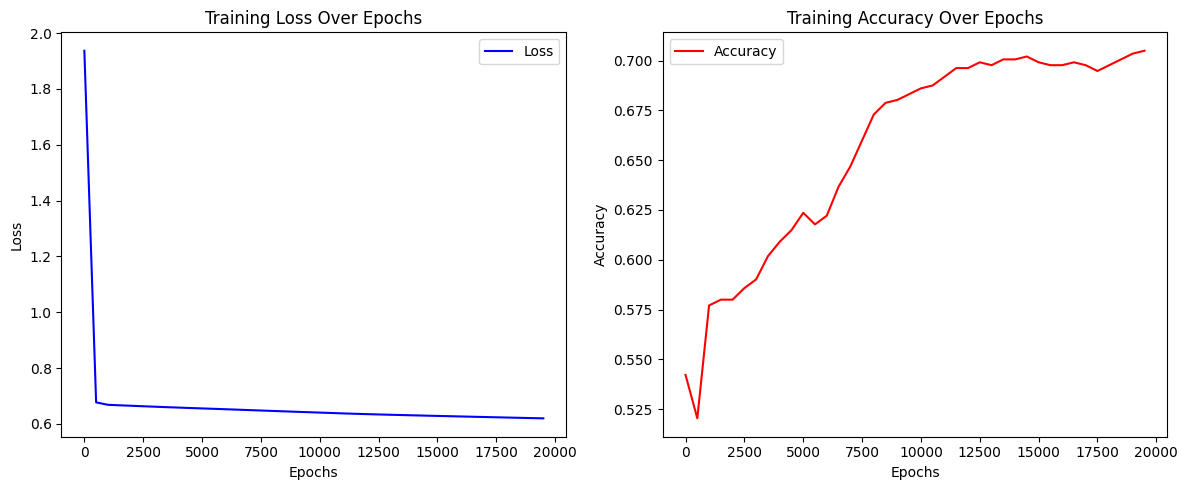

In [57]:
plot_side_by_side(epoch_arr, train_loss, train_accu, "Training")

#### Plotting Loss and Accuracy over epochs for Test Data

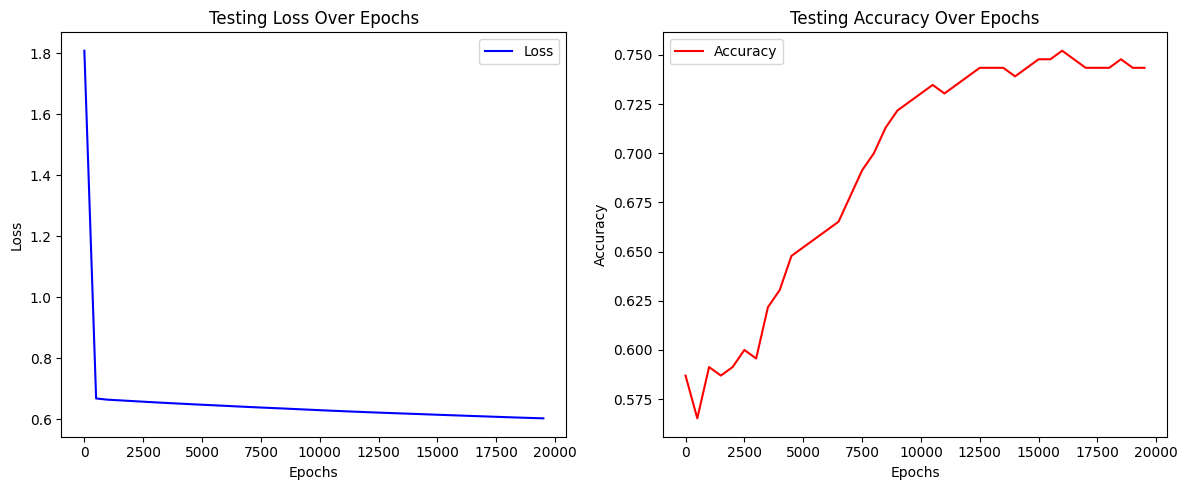

In [58]:
plot_side_by_side(epoch_arr, test_loss, test_accu, "Testing")

### Testing the model

In [59]:
model.eval()
with torch.inference_mode():
    test_output = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_output))

test_pred[:10], y_test[:10] 

(tensor([0., 0., 0., 0., 1., 1., 1., 1., 0., 1.]),
 tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 1.]))

### Calculating Metrics

In [60]:
accuracy = accuracy_score(y_test, test_pred)
precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)

print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}')
print(f'Recall: {recall*100:.2f}')
print(f'F1 Score: {f1*100:.2f}')

Accuracy: 74.35%
Precision: 77.94
Recall: 78.52
F1 Score: 78.23


### Plotting Actual vs Predicted values

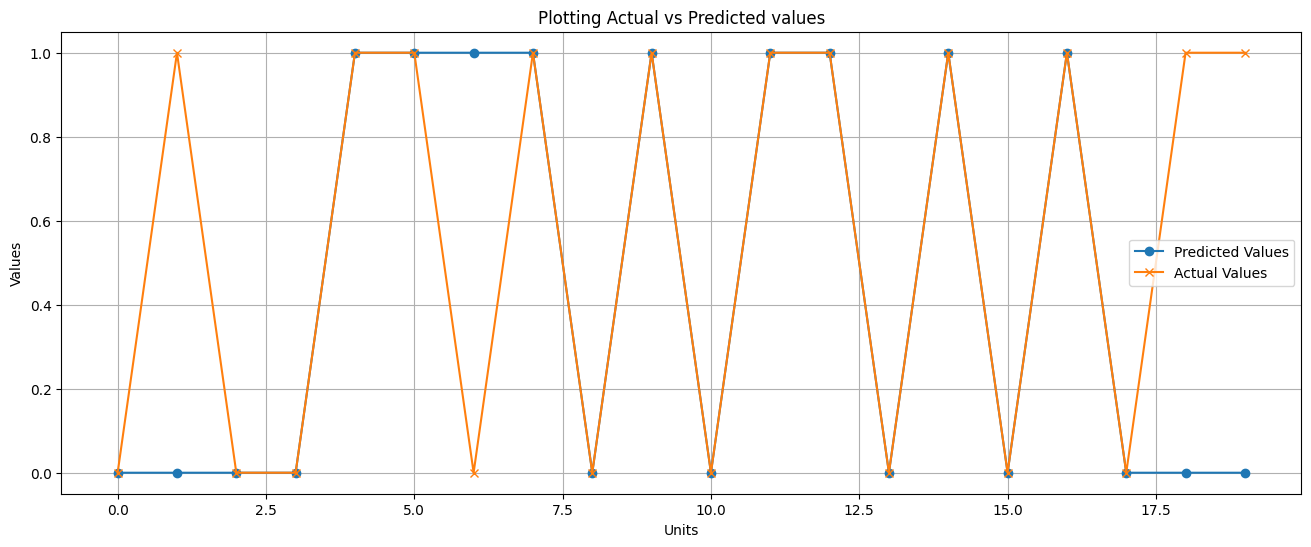

In [63]:
plt.figure(figsize=(16,6))
plt.plot(test_pred[:20], label='Predicted Values', marker='o')
plt.plot(y_test[:20], label='Actual Values', marker='x')
plt.title('Plotting Actual vs Predicted values')
plt.xlabel("Units")
plt.ylabel("Values")
plt.grid()
plt.legend()
plt.show()

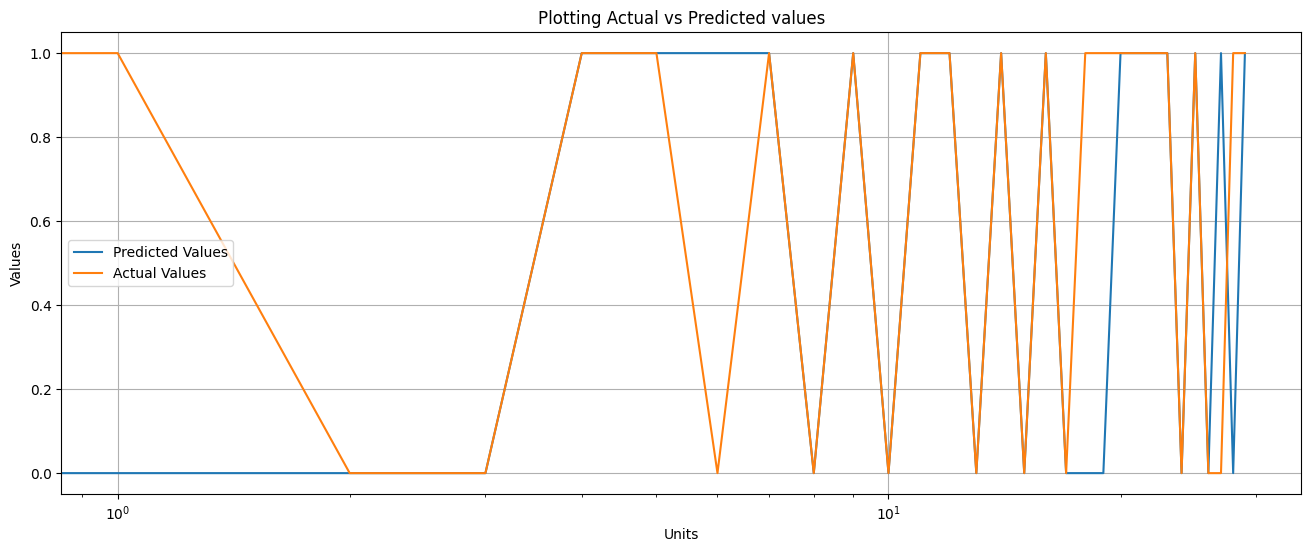

In [67]:
# scaled plot
plt.figure(figsize=(16,6))
plt.plot(test_pred[:30], label='Predicted Values')
plt.plot(y_test[:30], label='Actual Values')
plt.title('Plotting Actual vs Predicted values')
plt.xlabel("Units")
plt.ylabel("Values")
plt.xscale("log")
plt.grid()
plt.legend()
plt.show()